In [267]:
import awkward as ak
from pathlib import Path
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

# Classes

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self['data'].fields:
            for i, bpm in enumerate(self['data'][crate]['ChannelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self['data'][crate]['Positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

# Orbit plot

In [302]:
bpms_path = Path('/Users/lisepauwels/sps_simulations/MD_data/20251010/bpms/')
data = ak.Array(ak.from_parquet(Path(bpms_path, '2025-10-10T12_50_10.parquet')),with_name='BPMCollection')

line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw_ref = line.twiss()

def get_bpm_in_line(bpm_name):
    return bpm_name if bpm_name != 'bph.41608' else 'bph.41607'

mask_bpm = np.array([True if bpm not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] else False for bpm in data.bpms_hor])
mask_acq = np.array([False if len(np.unique(data.hor_turn_position[i]))==1 else True for i in range(len(data.bpms_hor))])
mask = (mask_bpm & mask_acq)

s_positions_bpms = []
for bpm in data.bpms_hor[mask]:
    s_positions_bpms.append(line.get_s_position(f'{get_bpm_in_line(bpm)}'))

s_positions_bpms = np.array(s_positions_bpms)

min_acq_number = np.min([len(bpm) for bpm in data.hor_turn_position])

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


## Orbit alone over time

Text(0, 0.5, 'Horizontal Turn Position [mm]')

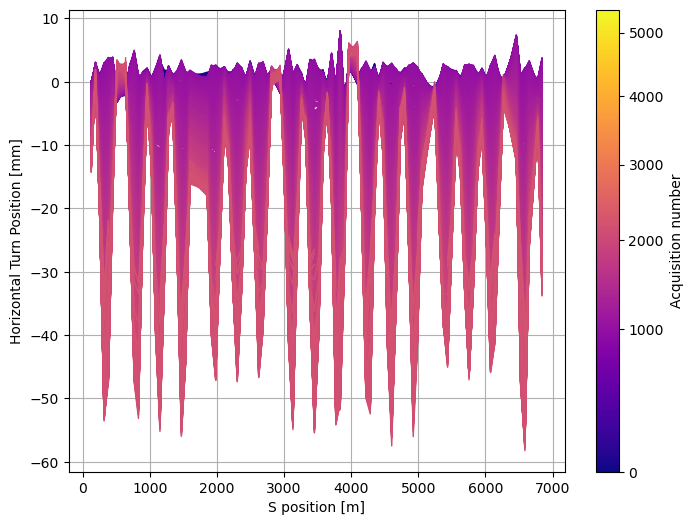

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=0, vmax=min_acq_number-1)
norm = colors.PowerNorm(gamma=0.7, vmin=0, vmax=min_acq_number - 1)
for i in range(min_acq_number):
    ax.plot(
        s_positions_bpms,
        data.hor_turn_position[mask][:, i],
        color=cmap(norm(i)),
        lw=1
    )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Acquisition number")
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

# Adding apertures on the orbit

In [8]:
import apertls

In [9]:
line_ap_calc = apertls.ApertureCalculator(line)
x_extent = line_ap_calc.compute_x_extent()
y_extent = line_ap_calc.compute_y_extent()

x_min = x_extent[:,0]
x_max = x_extent[:,1]
y_min = y_extent[:,0]
y_max = y_extent[:,1]

In [10]:
mask_apertures = [el.startswith('Limit') for el in tt.element_type]

Text(0, 0.5, 'Horizontal Turn Position [mm]')

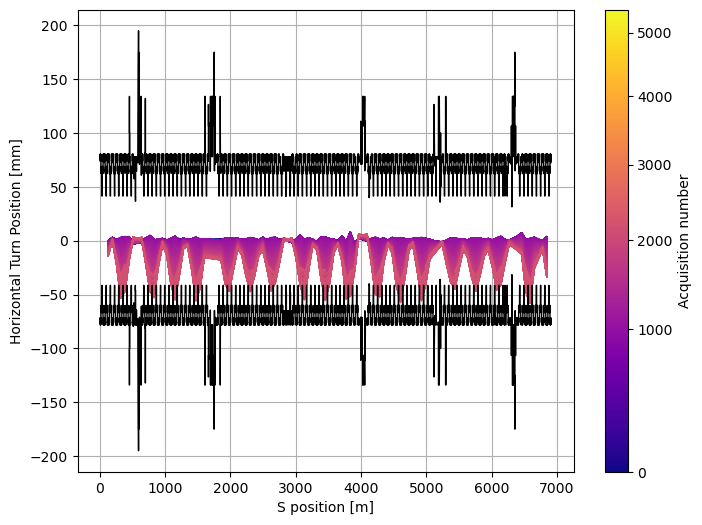

In [111]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('plasma')
# norm = colors.Normalize(vmin=0, vmax=min_acq_number-1)
norm = colors.PowerNorm(gamma=0.7, vmin=0, vmax=min_acq_number - 1)
for i in range(min_acq_number):
    ax.plot(
        s_positions_bpms,
        data.hor_turn_position[mask][:, i],
        color=cmap(norm(i)),
        lw=1
    )

ax.plot(tt.s[mask_apertures], x_min*1e3, 'k-', lw=1)
ax.plot(tt.s[mask_apertures], x_max*1e3, 'k-', lw=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Acquisition number")
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

# Matching orbit in xsuite

In [303]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [304]:
def build_response_matrix(tw, monitor_names, corrector_names, plane=None):

    assert plane in ['x', 'y']

    # Build response matrix
    indices_monitors = tw.rows.indices[monitor_names]
    indices_correctors = tw.rows.indices[corrector_names]
    bet_monitors = tw['bet' + plane][indices_monitors]
    bet_correctors = tw['bet' + plane][indices_correctors]

    mu_monitor = tw['mu' + plane][indices_monitors]
    mux_correctors = tw['mu' + plane][indices_correctors]

    n_monitors = len(monitor_names)
    n_correctors = len(corrector_names)

    bet_prod = np.atleast_2d(bet_monitors).T @ np.atleast_2d(bet_correctors)
    mu_diff = (np.tile(mu_monitor, (n_correctors, 1)).T
                        - np.tile(mux_correctors, (n_monitors, 1)))

    # Slide 28
    # https://indico.cern.ch/event/1328128/contributions/5589794/attachments/2786478/4858384/linearimperfections_2024.pdf
    tune = tw['q' + plane]
    response_matrix = (np.sqrt(bet_prod) / 2 / np.sin(np.pi * tune)
                            * np.cos(np.pi * tune - 2*np.pi*np.abs(mu_diff)))

    return response_matrix

# """
#     Construct response matrix
#     """
#     response_matrix_H = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_H, 
#         corrector_names=errors_H, 
#         plane='x')
#     response_matrix_V = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_V, 
#         corrector_names=errors_V, 
#         plane='y')
    

#     """
#     Calculate necessary errors
#     """
#     U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
#     threshold_H = 1e-3 * np.max(sigma_H)
#     sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
#     M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
#     k_H = M_pseudo_inv_H @ target_val_H

#     U_V, sigma_V, VT_V = np.linalg.svd(response_matrix_V, full_matrices=False)
#     threshold_V = 1e-4 * np.max(sigma_V)
#     sigma_inv_V = np.array([1/s if s > threshold_V else 0 for s in sigma_V])
#     M_pseudo_inv_V = VT_V.T @ np.diag(sigma_inv_V) @ U_V.T
#     k_V = M_pseudo_inv_V @ target_val_V


In [305]:
error_locs_H = []
for i in range(len(line.element_names)):
    name = line.element_names[i]
    if name.startswith("qf."):
        error_locs_H.append(name)

In [306]:
line.discard_tracker()

for i in range(len(error_locs_H)):
    print("Adding H error", i+1, "out of", len(error_locs_H))

    error_loc_name = re.split(r"[._]", error_locs_H[i])
    knl_name = "knl_err_" + error_loc_name[0] + error_loc_name[1]
    errname = "errH_" + error_loc_name[0] + error_loc_name[1]

    line.vars[knl_name] = 0.0

    curr_multipole_error = xt.Multipole(knl=[0.0], ksl=[0.0])
    curr_idx = np.where(np.asarray(line.element_names) == error_locs_H[i])[0][0] + 1
    line.insert_element(element=curr_multipole_error, name=errname, at=curr_idx)

    line.element_refs[errname].knl[0] = line.vars[knl_name]

Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H error 34 out of 102
Adding H error 35 out o

In [307]:
line.build_tracker()

In [308]:
errors_H = []
for name in line.element_names:
    if "errH" in name:
        errors_H.append(name)

In [309]:
tw_ref = line.twiss()

In [310]:
response_matrix_H = build_response_matrix(
        tw=tw_ref, 
        monitor_names=[f'{get_bpm_in_line(name)}' for name in data.bpms_hor[mask]], 
        corrector_names=errors_H, 
        plane='x')

In [315]:
U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
threshold_H = 1e-2 * np.max(sigma_H)
# threshold_H = 1e-3 * np.min(sigma_H)
sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
k_H = M_pseudo_inv_H @ ak.to_numpy(np.nanmean(data.hor_turn_position[mask][:, :5], axis=1)*1e-3)

[]

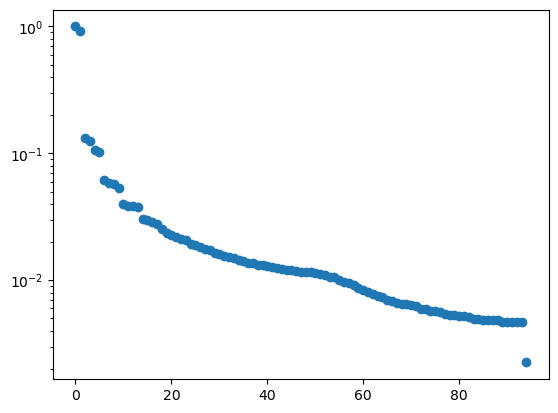

In [314]:
plt.plot(sigma_H / np.max(sigma_H), 'o')
plt.semilogy()

In [316]:
m = np.nanmean(data.hor_turn_position[mask][:, :5], axis=1)

In [317]:
vary_H = []
for var_name in line.vars.keys():
    if "knl_err" in var_name:
        vary_H.append(var_name)

In [318]:
for i in range(len(vary_H)):
    line.vv[vary_H[i]] = k_H[i] * -1

In [319]:
tw = line.twiss()

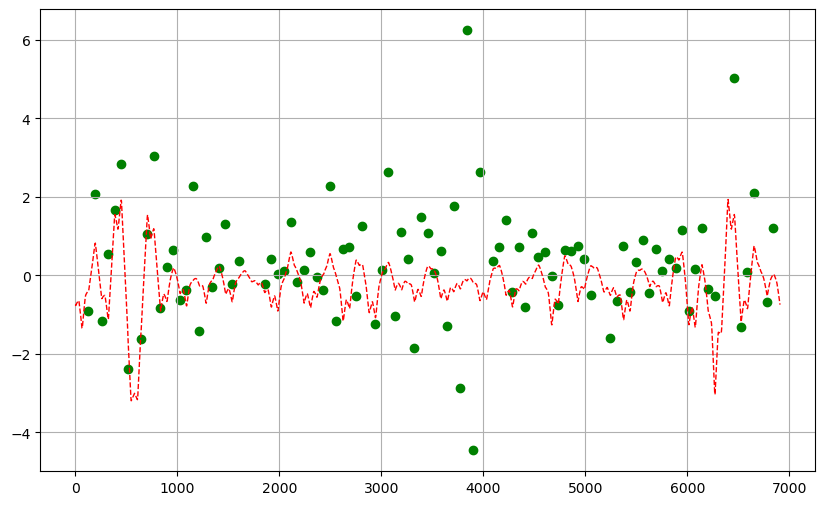

In [320]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(s_positions_bpms, m, color='green', label='MD data')
ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
ax.grid()

# Comparing orbits for SVD, micado corr, "no corr" and zero corr

In [255]:
# Finding timestamps
files = {'REF_SVD_CORR_1.2_0.8_NEG' : ['2025-10-10T12_50_10.parquet', '2025-10-10T12_50_28.parquet',  '2025-10-10T12_50_46.parquet'],
         'REF_SVD_CORR_1.2_0.8_POS' : ['2025-10-10T12_48_04.parquet', '2025-10-10T12_48_22.parquet',  '2025-10-10T12_48_40.parquet'],
         'REF_MICADO_CORR_NEG' : ['2025-10-10T12_10_49.parquet', '2025-10-10T12_11_07.parquet',  '2025-10-10T12_11_25.parquet'],
         'REF_MICADO_CORR_POS' : ['2025-10-10T12_13_13.parquet', '2025-10-10T12_13_31.parquet',  '2025-10-10T12_13_49.parquet'],
         'REF_NO_CORR_NEG' : ['2025-10-10T11_25_42.parquet', '2025-10-10T11_26_00.parquet',  '2025-10-10T11_27_30.parquet'],
         'REF_NO_CORR_POS' : ['2025-10-10T11_58_49.parquet', '2025-10-10T11_59_07.parquet',  '2025-10-10T11_59_25.parquet'],
         'REF_ZERO_CORR_NEG' : ['2025-10-10T11_34_42.parquet', '2025-10-10T11_35_00.parquet',  '2025-10-10T11_35_18.parquet'],
         'REF_ZERO_CORR_POS' : ['2025-10-10T11_53_07.parquet', '2025-10-10T11_53_25.parquet',  '2025-10-10T11_53_43.parquet']}

bpms_path = Path('/Users/lisepauwels/sps_simulations/MD_data/20251010/bpms/')
data = {}
for key, value in files.items():
    data[key] = []
    for f in value:
        data[key].append(ak.Array(ak.from_parquet(Path(bpms_path, f)), with_name='BPMCollection'))

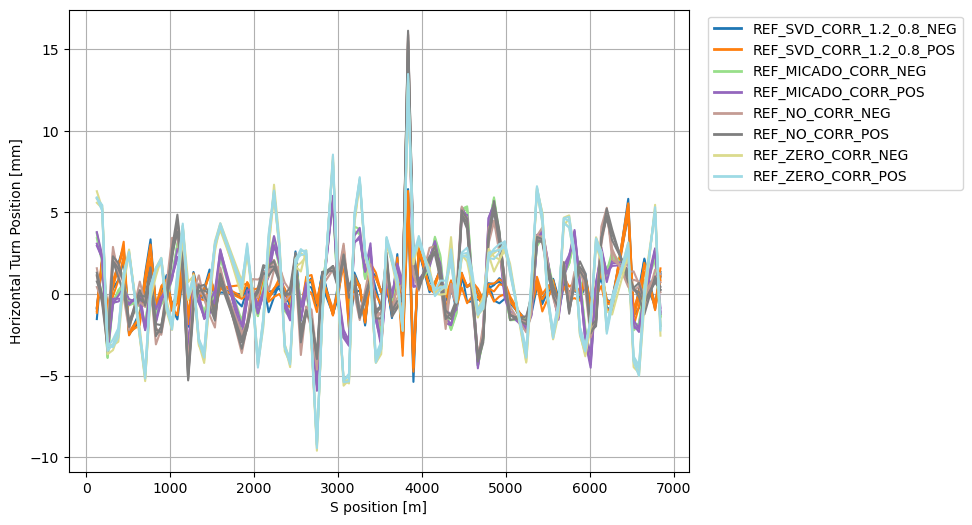

In [277]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('tab20')
norm = colors.Normalize(vmin=0, vmax=len(data.keys())-1)
colors_dict = {}
mean_orbits = {}
for key in data.keys():
    color = cmap(norm(list(data.keys()).index(key)))
    colors_dict[key] = color
    mean_orbits[key] = []
    for i in range(len(data[key])):
        mean_orbit = np.nanmean(data[key][i].hor_turn_position[mask][:, :5], axis=1)
        mean_orbits[key].append(mean_orbit)
        ax.plot(s_positions_bpms, mean_orbit, label=key, color=color)
ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')

color_handles = [
    Line2D([0], [0], color=color, lw=2, label=name)
    for name, color in colors_dict.items()
]

ax.legend(handles=color_handles, bbox_to_anchor=(1.02, 1), loc='upper left')

In [278]:
orbits = {key : np.mean(mean_orbits[key], axis=0) for key in mean_orbits}

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

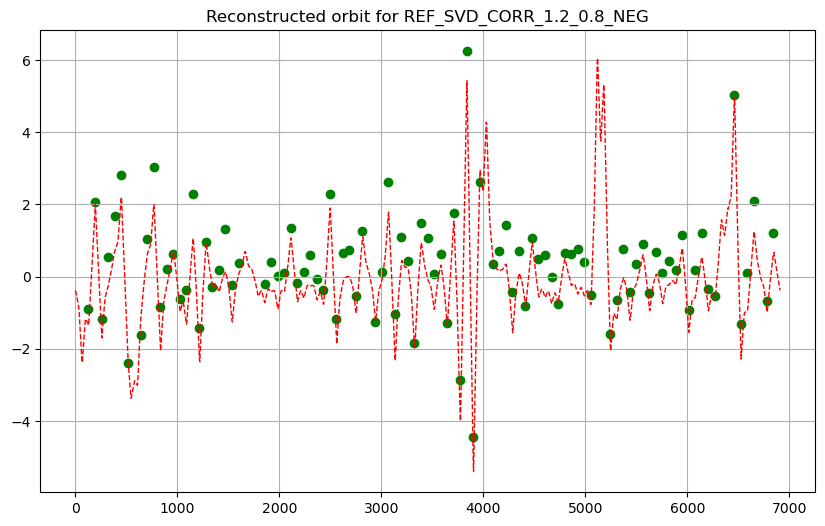

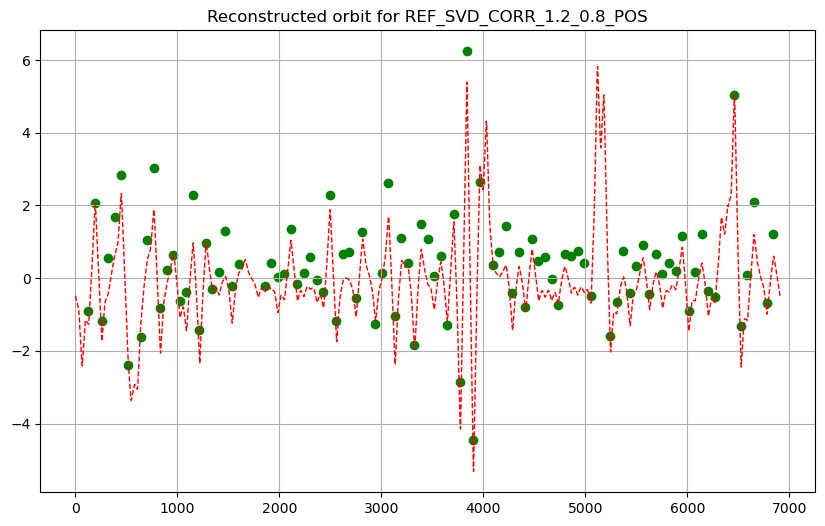

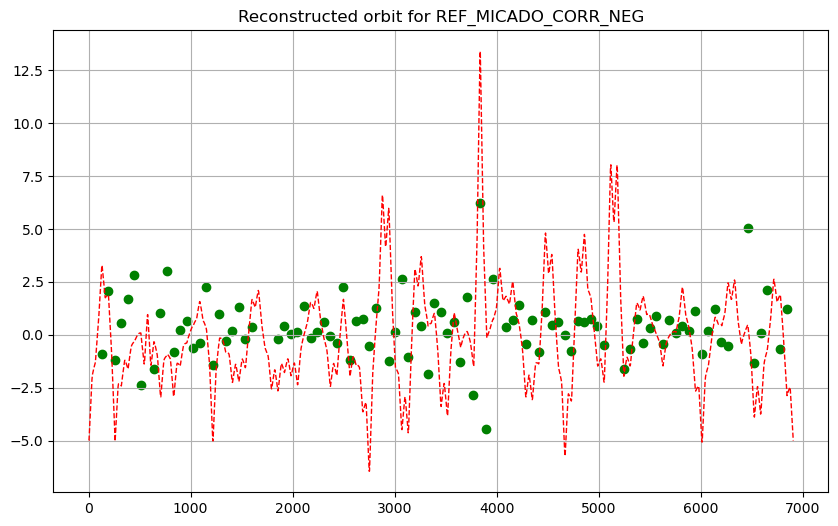

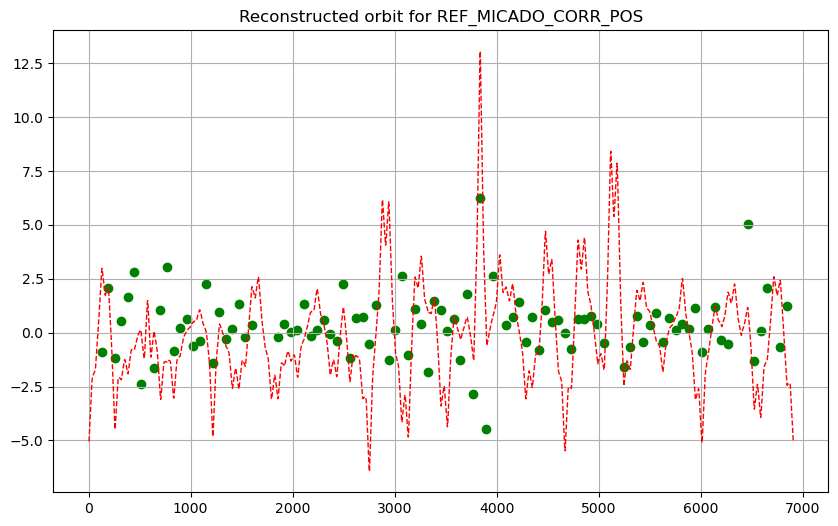

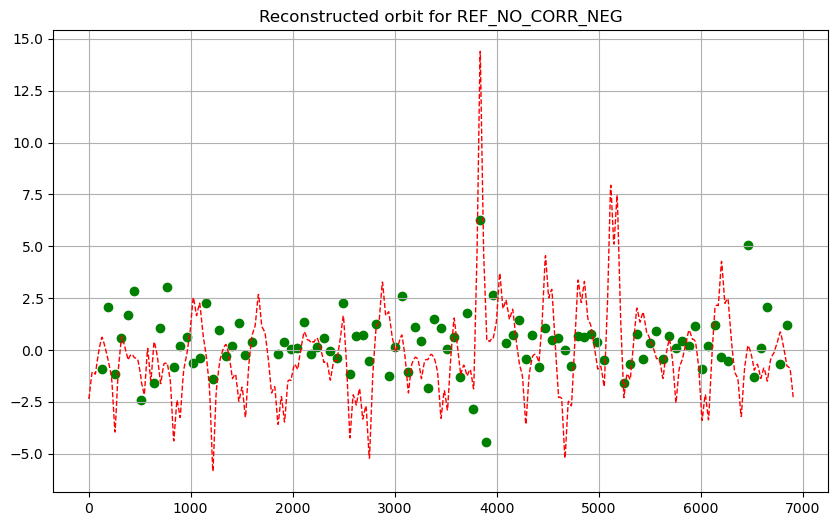

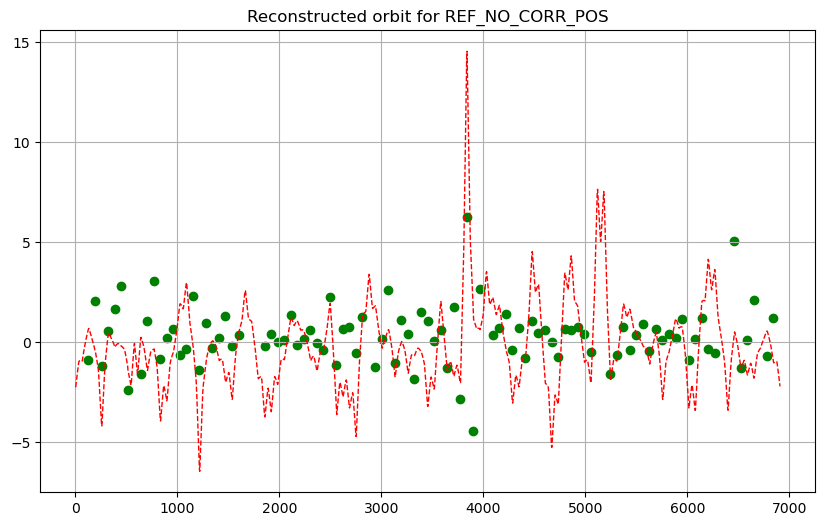

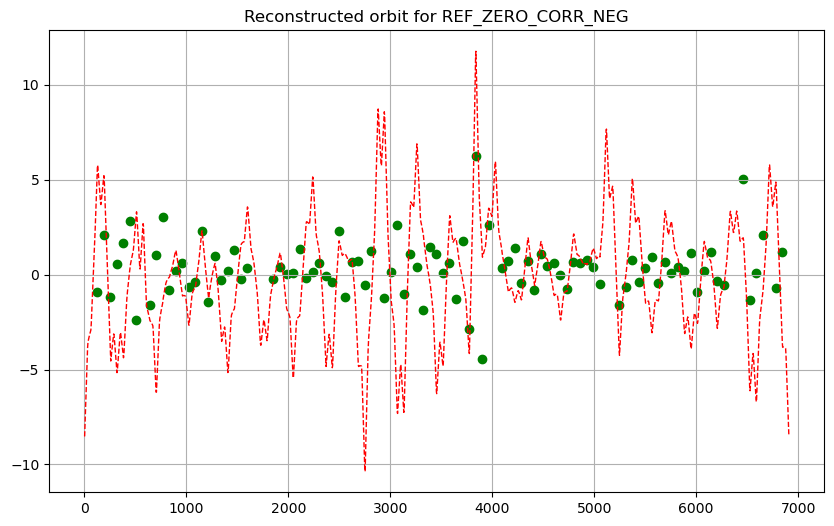

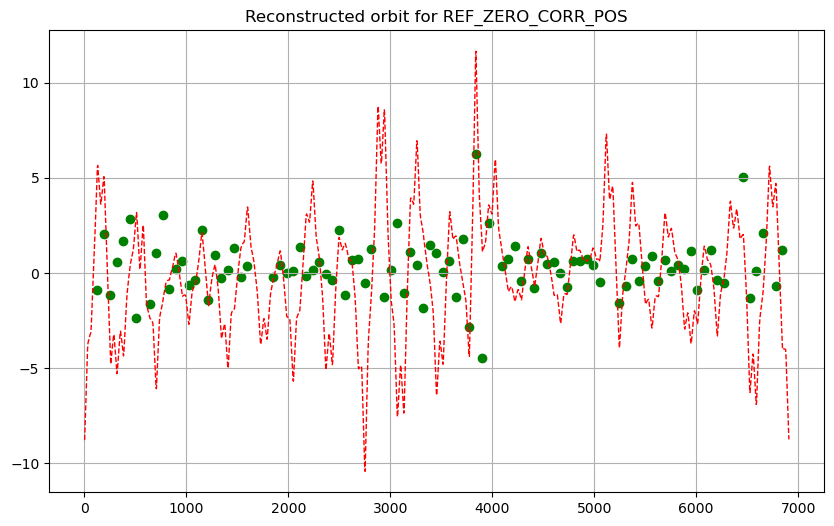

In [292]:
reconstructed_orbit_lines = {}
for key in orbits.keys():
    line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
    tt = line.get_table()
    tw_ref = line.twiss()

    error_locs_H = []
    for i in range(len(line.element_names)):
        name = line.element_names[i]
        if name.startswith("qf."):
            error_locs_H.append(name)
    
    line.discard_tracker()

    for i in range(len(error_locs_H)):
        print("Adding H error", i+1, "out of", len(error_locs_H))

        error_loc_name = re.split(r"[._]", error_locs_H[i])
        knl_name = "knl_err_" + error_loc_name[0] + error_loc_name[1]
        errname = "errH_" + error_loc_name[0] + error_loc_name[1]

        line.vars[knl_name] = 0.0

        curr_multipole_error = xt.Multipole(knl=[0.0], ksl=[0.0])
        curr_idx = np.where(np.asarray(line.element_names) == error_locs_H[i])[0][0] + 1
        line.insert_element(element=curr_multipole_error, name=errname, at=curr_idx)

        line.element_refs[errname].knl[0] = line.vars[knl_name]

    line.build_tracker()
    
    errors_H = []
    for name in line.element_names:
        if "errH" in name:
            errors_H.append(name)
    
    tw_ref = line.twiss()
    
    response_matrix_H = build_response_matrix(
        tw=tw_ref, 
        monitor_names=[f'{get_bpm_in_line(name)}' for name in data[key][0].bpms_hor[mask]], 
        corrector_names=errors_H, 
        plane='x')
    
    U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
    # threshold_H = 5e-3 * np.max(sigma_H)
    threshold_H = 1e-3 * np.min(sigma_H)
    sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
    M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
    k_H = M_pseudo_inv_H @ ak.to_numpy(orbits[key]*1e-3)

    vary_H = []
    for var_name in line.vars.keys():
        if "knl_err" in var_name:
            vary_H.append(var_name)

    for i in range(len(vary_H)):
        line.vv[vary_H[i]] = k_H[i] * -1
    tw = line.twiss()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(s_positions_bpms, m, color='green', label='MD data')
    ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
    ax.grid()
    ax.set_title(f'Reconstructed orbit for {key}')
    reconstructed_orbit_lines[key] = line.copy()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H err

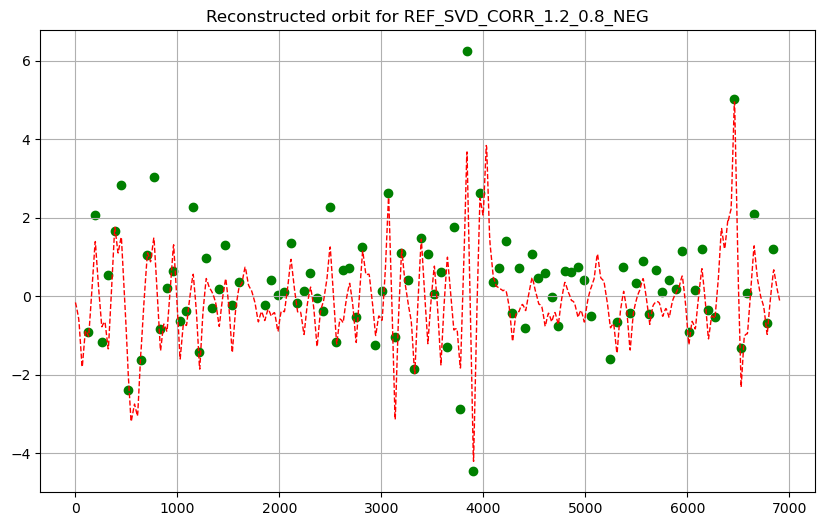

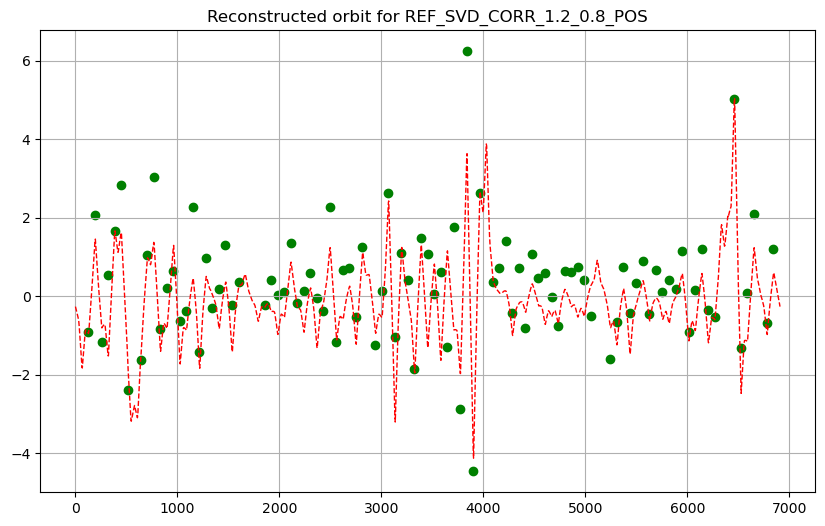

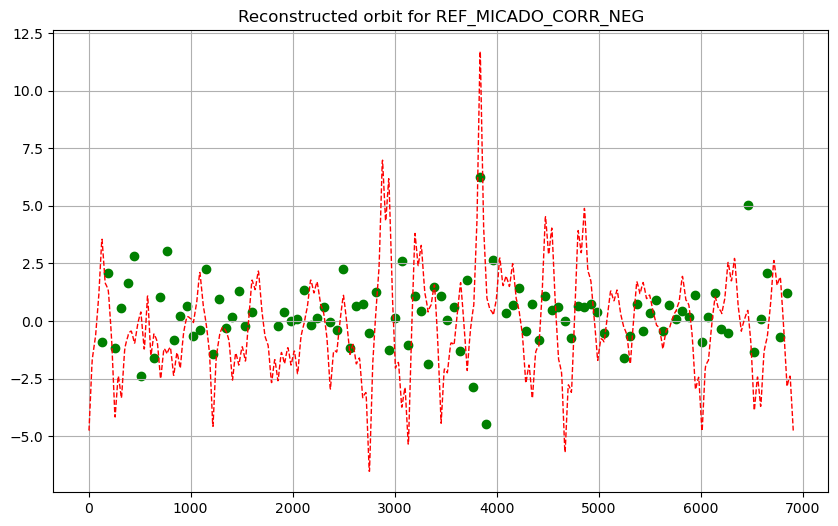

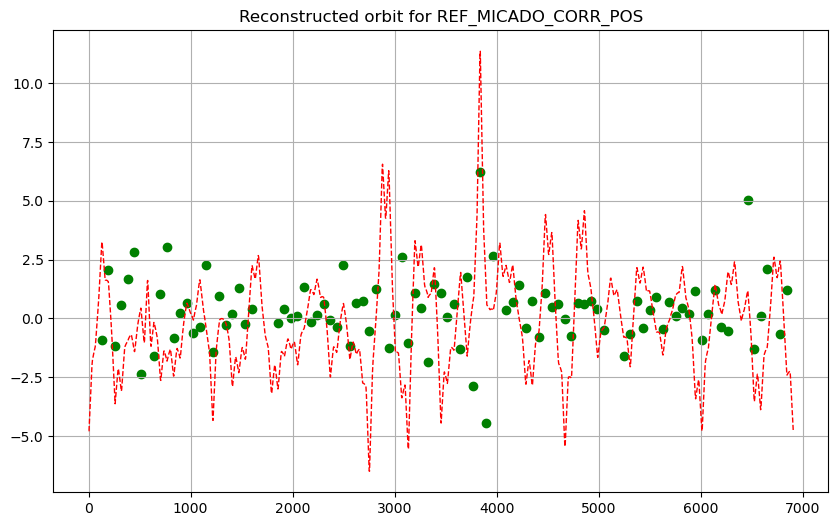

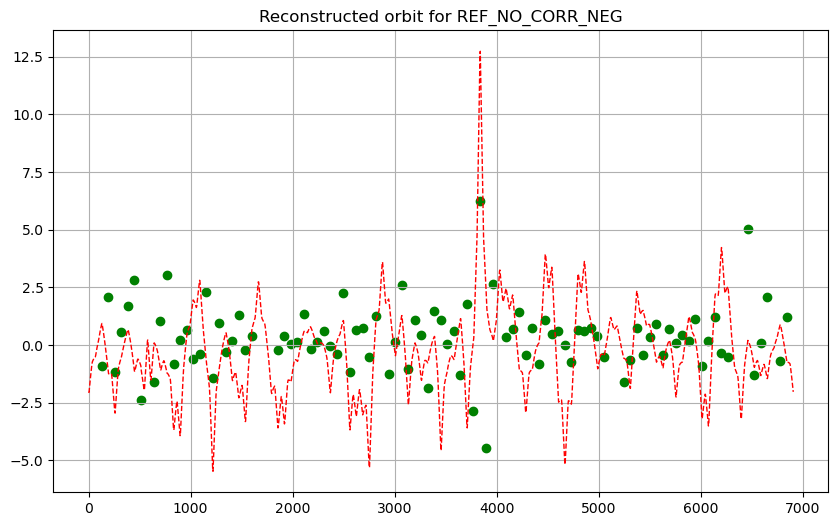

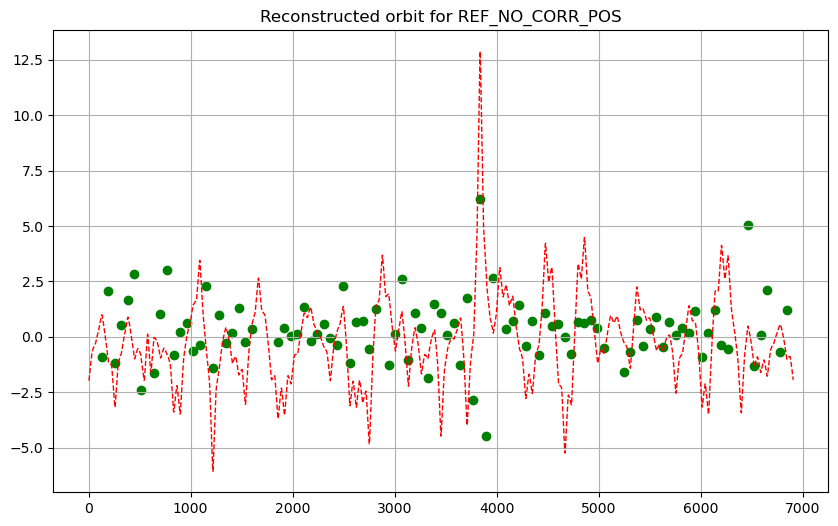

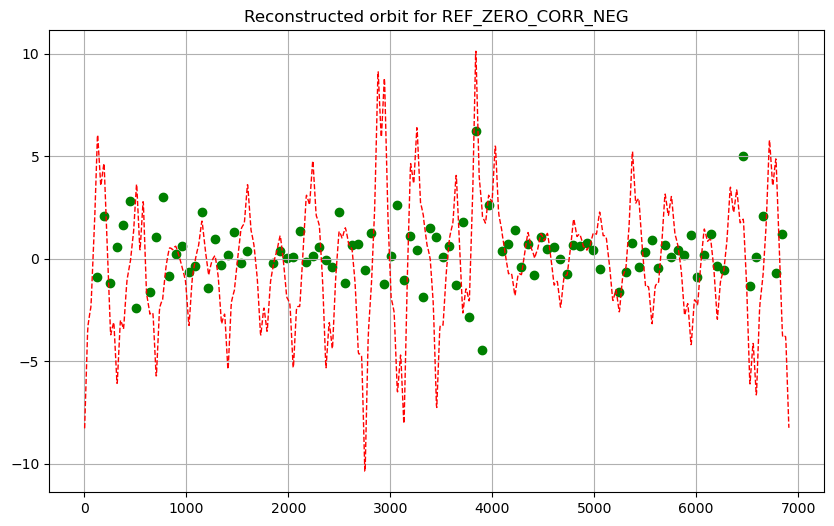

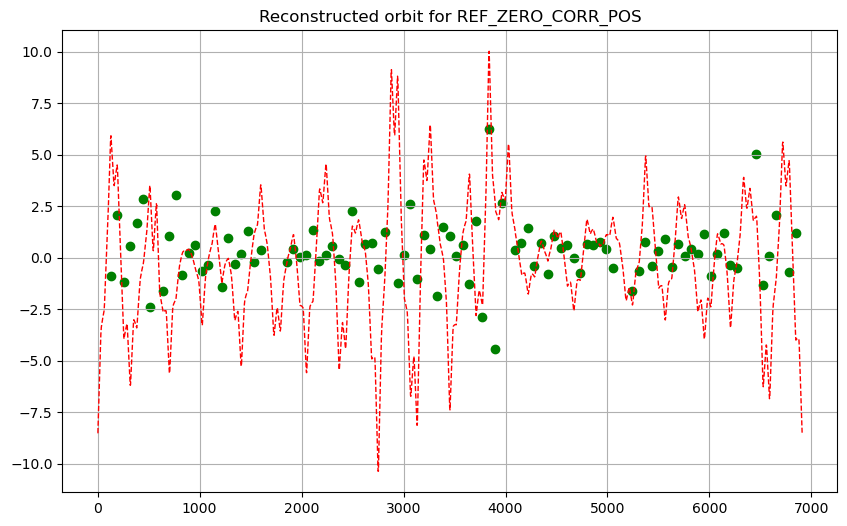

In [ ]:
reconstructed_orbit_lines2 = {}
for key in orbits.keys():
    line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
    tt = line.get_table()
    tw_ref = line.twiss()

    error_locs_H = []
    for i in range(len(line.element_names)):
        name = line.element_names[i]
        if name.startswith("qf."):
            error_locs_H.append(name)
    
    line.discard_tracker()

    for i in range(len(error_locs_H)):
        print("Adding H error", i+1, "out of", len(error_locs_H))

        error_loc_name = re.split(r"[._]", error_locs_H[i])
        knl_name = "knl_err_" + error_loc_name[0] + error_loc_name[1]
        errname = "errH_" + error_loc_name[0] + error_loc_name[1]

        line.vars[knl_name] = 0.0

        curr_multipole_error = xt.Multipole(knl=[0.0], ksl=[0.0])
        curr_idx = np.where(np.asarray(line.element_names) == error_locs_H[i])[0][0] + 1
        line.insert_element(element=curr_multipole_error, name=errname, at=curr_idx)

        line.element_refs[errname].knl[0] = line.vars[knl_name]

    line.build_tracker()
    
    errors_H = []
    for name in line.element_names:
        if "errH" in name:
            errors_H.append(name)
    
    tw_ref = line.twiss()
    
    response_matrix_H = build_response_matrix(
        tw=tw_ref, 
        monitor_names=[f'{get_bpm_in_line(name)}' for name in data[key][0].bpms_hor[mask]], 
        corrector_names=errors_H, 
        plane='x')
    
    U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
    threshold_H = 5e-3 * np.max(sigma_H)
    # threshold_H = 1e-3 * np.min(sigma_H)
    sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
    M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
    k_H = M_pseudo_inv_H @ ak.to_numpy(orbits[key]*1e-3)

    vary_H = []
    for var_name in line.vars.keys():
        if "knl_err" in var_name:
            vary_H.append(var_name)

    for i in range(len(vary_H)):
        line.vv[vary_H[i]] = k_H[i] * -1
    tw = line.twiss()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(s_positions_bpms, m, color='green', label='MD data')
    ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
    ax.grid()
    ax.set_title(f'Reconstructed orbit for {key}')
    reconstructed_orbit_lines2[key] = line.copy()

In [298]:
# Error of the reconstruction
mask_bpm_line = np.array([nn.startswith('bph.') and nn not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] for nn in line.element_names])

norm_errors = {}
for key in orbits.keys():
    line1 = reconstructed_orbit_lines[key]
    tw1 = line1.twiss()
    line2 = reconstructed_orbit_lines2[key]
    tw2 = line2.twiss()
    
    orbit1 = tw1.x[mask_bpm_line] * 1e3
    orbit2 = tw2.x[mask_bpm_line] * 1e3
    diff_orbit = orbit1 - orbit2

    norm_errors[key] = [np.linalg.norm(orbits[key] - orbit1)/np.linalg.norm(orbits[key]), np.linalg.norm(orbit2 - orbits[key])/np.linalg.norm(orbits[key])]


IndexError: boolean index did not match indexed array along axis 0; size of axis is 32641 but size of corresponding boolean axis is 32640

In [301]:
len(mask_bpm_line), len(line1.element_names)

(32640, 32640)

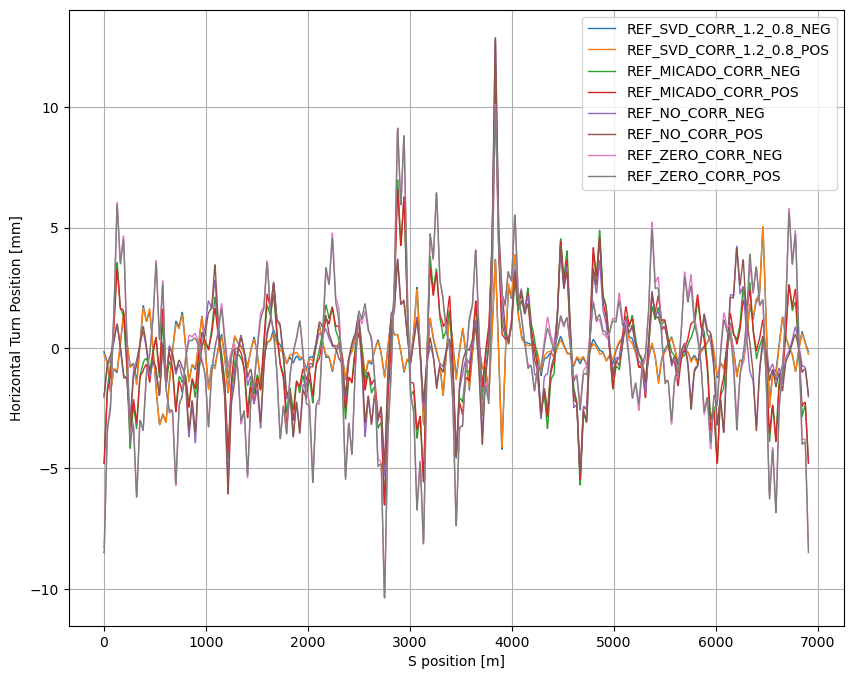

In [284]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

for key in reconstructed_orbit_lines.keys():
    line = reconstructed_orbit_lines[key]
    tw = line.twiss()
    ax.plot(tw.s, tw.x * 1e3, '-', lw=1, label=key)

ax.grid()
ax.set_xlabel('S position [m]')
ax.set_ylabel('Horizontal Turn Position [mm]')
ax.legend()